In [1]:
import os
os.chdir(f"/home/{os.getlogin()}/watttime-python-client-aer-algo")

In [20]:
import pytz

In [2]:
from eda.load_data import get_historical_forecast_pandas, get_historical
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
import evaluation.eval_framework as efu
import data.s3 as s3u

In [4]:
region = "PJM_CHICAGO"
start = '2024-07-15 00:00Z'
end = '2024-07-20 00:00Z'

In [ ]:
def convert_from_utc(local_time_str, local_tz_str):
    """
    Convert a time expressed in UTC to any timezone

    Parameters:
    local_time_str (str): The local time as a pd.Timestamp.
    local_tz_str (str): The timezone of the local time as a string, e.g., 'America/New_York'.

    Returns:
    str: The time in UTC as a datetime object in the format 'YYYY-MM-DD HH:MM:SS'.
    """
    # Parse the local time string to a datetime object
    local_time = datetime.strptime(
        local_time_str.strftime("%Y-%m-%d %H:%M:%S"), "%Y-%m-%d %H:%M:%S"
    )

    # Set the timezone
    local_tz = pytz.timezone(pytz.utc)

    # Localize the local time to the local timezone
    local_time = local_tz.localize(local_time)

    # Return the UTC time as a datetime
    return local_time.astimezone(pytz.utc)

In [30]:
from datetime import datetime

In [34]:
df.index = [pd.Timestamp(x).astimezone('America/New_York') for x in df.index]

In [44]:
new_cols = [str(pd.Timestamp(x).astimezone('America/New_York')) for x in df.columns[:-1]] + [df.columns[-1]]

In [46]:
df.columns = new_cols

In [5]:
def get_forecasts_and_actual(region, start, end):
    df_actual = get_historical(region, start, end)
    df_piv = get_historical_forecast_pandas(region, start, end)

    # subsample down to one forecast per hour and just one day
    df = df_piv[df_piv.columns[0::12]].loc[:start.split(" ")[0]]
    
    # add in actual MOER
    df = pd.concat([df, df_actual.iloc[:-1]], axis=1)
    return df

In [6]:
def plot_forecasts_and_actual(df,region):
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

    # Plot all columns except 'CAISO_NORTH'
    for column in df.columns:
        if column != region:
            plt.plot(df.index, df[column], label=pd.to_datetime(column).strftime('%Y-%m-%d'))

    # Plot 'CAISO_NORTH' with a dotted line
    plt.plot(df.index, df[region], label=region, linestyle='--', linewidth=3, color="k")

    plt.xlabel('time')
    plt.ylabel('MOER (CO2 lbs/MWh)')
    plt.title('Actual signal (dotted) and forecasts')
    plt.grid(True)
    plt.show()

In [7]:
def plot_forecasts_and_actual_diffs(df,region):
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

    # Plot all columns except 'CAISO_NORTH'
    for column in df.columns:
        if column != region:
            plt.plot(df.index, df[column], label=pd.to_datetime(column).strftime('%Y-%m-%d'))

    # Plot 'CAISO_NORTH' with a dotted line
    #plt.plot(df.index, df[region], label=region, linestyle='--', linewidth=3, color="k")

    plt.xlabel('time')
    plt.ylabel('MOER (CO2 lbs/MWh)')
    plt.title('Actual signal (dotted) and forecasts')
    plt.grid(True)
    plt.show()

In [8]:
df = get_forecasts_and_actual(region, start, end)

loading regions: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


In [10]:
s3 = s3u.s3_utils()
key = '20240725_action_forecast_pjm_chicago.csv'
s3.store_csvdataframe(dataframe=df, file=key)

Successful S3 put_object response. Status - 200


<Axes: >

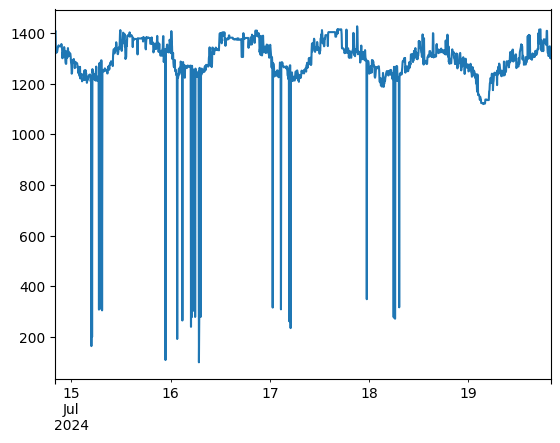

In [47]:
df["PJM_CHICAGO"].plot(kind='line')

In [77]:
df.isnull().sum()

2024-07-14 20:00:00-04:00    1152
2024-07-14 21:00:00-04:00    1164
2024-07-14 22:00:00-04:00    1176
2024-07-14 23:00:00-04:00    1188
2024-07-15 00:00:00-04:00    1200
                             ... 
2024-07-19 17:00:00-04:00    1440
2024-07-19 18:00:00-04:00    1440
2024-07-19 19:00:00-04:00    1440
2024-07-19 20:00:00-04:00    1440
PJM_CHICAGO                     0
Length: 122, dtype: int64

<Axes: >

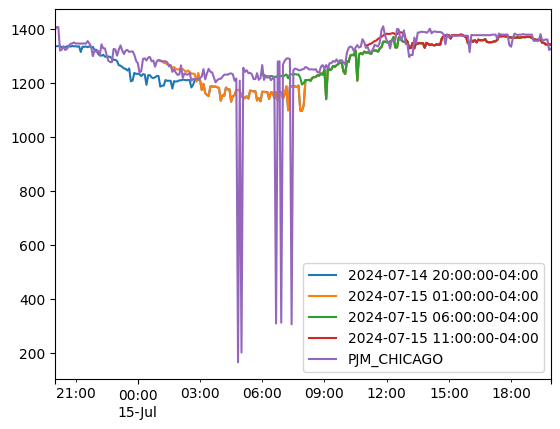

In [88]:
df[[df.columns[0], df.columns[5], df.columns[10], df.columns[15],"PJM_CHICAGO"]].head(288).plot(kind="line")

<Axes: >

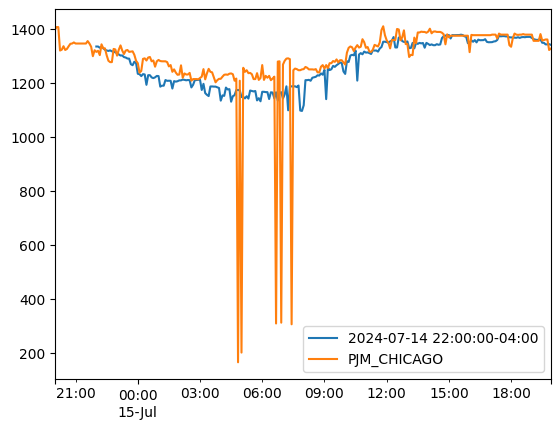

In [79]:
df[[df.columns[2],"PJM_CHICAGO"]].head(288).plot(kind="line")

In [55]:
#df[72:148]

<Axes: xlabel='point_time'>

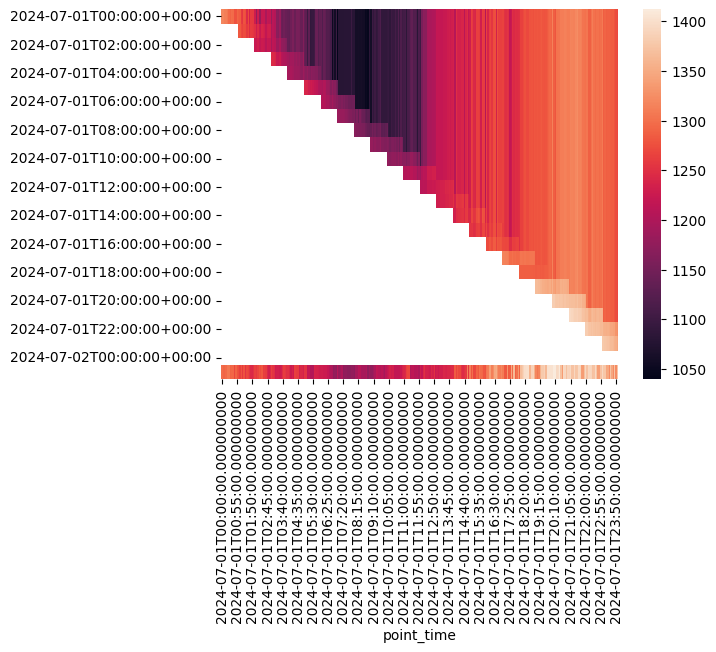

In [10]:
# we can plot two time-axis to show how the forecast evolves over time
# the x-axis is the time the forecast is for
# the y-axis is the time the forecat was generated.
# so for example a vertical line corresponds to a single point in time;
# going down the vertical line corresponds to forecasts about that point
# in time generated later and later 
sns.heatmap(df.T, annot=False)